In [3]:
import arviz as az
import numpy as np
import pymc as pm

In [15]:
# データの準備
Y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sd = np.array([4, 5, 5,7, 7,9,3,7])
J = len(Y)

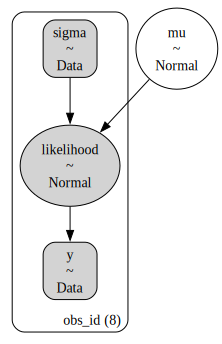

In [16]:
# プールモデルの構築
with pm.Model() as pooled:
    sigma = pm.Data('sigma',sd,dims="obs_id")
    y = pm.Data('y',Y,dims="obs_id")
    # 事前分布
    mu = pm.Normal("mu", 0, sigma=1e6)
    # 尤度
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y,dims="obs_id")

pm.model_to_graphviz(pooled)

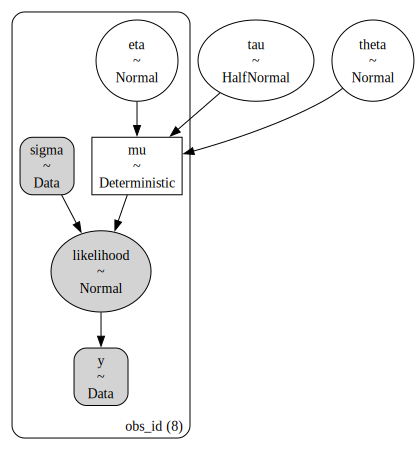

In [19]:
# 階層モデルの構築
with pm.Model() as hierarchical:
    sigma = pm.Data('sigma',sd,dims="obs_id")
    y = pm.Data('y',Y,dims="obs_id")
    # 階層モデルの事前分布
    eta = pm.Normal("eta", 0, 1, dims="obs_id")
    theta = pm.Normal("theta", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)
    # 線型予測子の定義
    mu = pm.Deterministic("mu", theta + tau * eta,dims="obs_id")
    # 尤度関数の定義
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y,dims="obs_id")

pm.model_to_graphviz(hierarchical)

In [21]:
# MCMCサンプリング
with pooled:
    trace_p = pm.sample(
        2000,
        tune=1000,
        nuts_sampler="numpyro",
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=42,
        target_accept=0.90,
        return_inferencedata=True
        )

with hierarchical:
    trace_h = pm.sample(
        2000,
        tune=1000,
        nuts_sampler="numpyro",
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=42,
        target_accept=0.90,
        return_inferencedata=True
        )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

-----------------------------
Pooled Model LOO:
Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -41.94     7.52
p_loo        5.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

-----------------------------

Hierarchical Model LOO:
Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -29.65     1.27
p_loo        5.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        2   25.0%
   (0.70, 1]   (bad)         6   75.0%
   (1, Inf)   (very bad)    0    0.0%

-----------------------------


/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

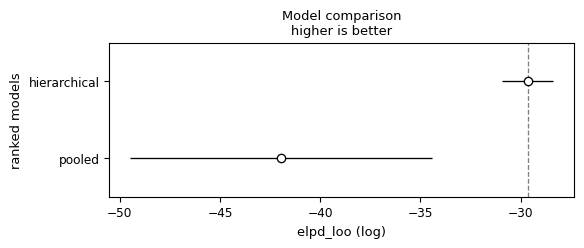

In [24]:
# LOOによるモデル比較
pooled_loo = az.loo(trace_p)
hierarchical_loo = az.loo(trace_h)

# モデル比較の結果の表示
print("-----------------------------")
print("Pooled Model LOO:")
print(pooled_loo)
print("-----------------------------")
print("\nHierarchical Model LOO:")
print(hierarchical_loo)
print("-----------------------------")

# モデル比較の結果をまとめる
df_comp_loo = az.compare({"pooled": trace_p, "hierarchical": trace_h})

# モデル比較結果のプロット
az.plot_compare(df_comp_loo, insample_dev=False)

-----------------------------
Pooled Model WAIC:
Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -41.89     7.54
p_waic        5.21        -

There has been a warning during the calculation. Please check the results.
-----------------------------

Hierarchical Model WAIC:
Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -27.51     0.81
p_waic        3.71        -

There has been a warning during the calculation. Please check the results.
-----------------------------


/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/yutaro

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

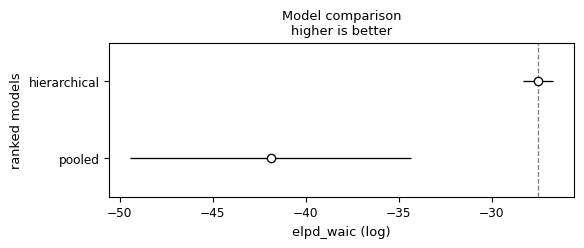

In [26]:
# LOOによるモデル比較
pooled_waic = az.waic(trace_p)
hierarchical_waic = az.waic(trace_h)

# モデル比較の結果の表示
print("-----------------------------")
print("Pooled Model WAIC:")
print(pooled_waic)
print("-----------------------------")
print("\nHierarchical Model WAIC:")
print(hierarchical_waic)
print("-----------------------------")

# モデル比較の結果をまとめる
df_comp_waic = az.compare({"pooled": trace_p, "hierarchical": trace_h}, ic="waic") # ic="waic" を指定

# モデル比較結果のプロット
az.plot_compare(df_comp_waic, insample_dev=False)